# IAM simulation
### Function originally written by Haoran and Keke, and organized by Yusong
### 2023/09/01, Menlo Park

In [1]:
%pwd

'/home/centurion/lheald2/GUED_Analysis/GUED_Analysis'

## Theory of Electron Scattering

See [Centurion et al](https://www.annualreviews.org/doi/abs/10.1146/annurev-physchem-082720-010539) for a full discription of the theory. 

Electrons being scattered by an arbitrary electric field, $V(\vec{r})$, can be described using the Born approximation to the Schrodinger equation via: 

\begin{equation}
\tag{1}
f(\vec{s}) = {m \over 2 \pi \hbar^{2}} \int exp(-i \vec{s} \cdot \vec{r'}) V(\vec{r'}) d^{3} r' \label{eq1}
\end{equation}

where $\vec{s}$ is the momentum transfer of the scattered electron with mass $m$. In MeV-UED experiments, the dominant electron-matter interaction is Coulombic, thus it is possible to represent the scattered wave function by a Fourier transform of the Coulombic potential field. 

\begin{equation}
\tag{2}
f(\vec{s}) = {m e \over 2 \pi \varepsilon_0 \hbar} {1 \over 2} \int exp(-i \vec{s} \cdot \vec{r}) \rho (\vec{r}) d^{3} r \label{eq2}
\end{equation} 

Here, $\rho(\vec{r})$ is the charge distribution of the sample and $s^{-2}$ is a prefactor. Equation 2 shows that the amplitude of the elastic scattering is proportional to the Fourier transform of $\rho(\vec{r})$.

The charge density of the nucleus and the electron of an atom with an atomic number $Z$ can be given by 

\begin{equation}
\tag{3}
\rho(r) = Ze\delta(\vec{r}) + \rho_{e}(r)
\end{equation} 

where $r$ is the radial dimension in spherical coordinates. In combination with the atomic form factor equation of X-ray scattering, $F(s)$

\begin{equation}
\tag{4}
F(s) = 4\pi \int \rho_{e}(r) {\sin (sr) \over sr} r^{2} dr
\end{equation} 

equation 2 can be rewritten as 

\begin{equation} 
\tag{5}
f(s) = {me^{2} \over 2 \pi \varepsilon_{0} \hbar^{2}} {1 \over 2} \lbrack Z-F(s) \rbrack
\end{equation} 

Assuming the independent atom model (IAM), the elastic scattering of a molecule made of $N$ atoms is defined as 

\begin{equation}
\tag{6}
f_{M}(\vec{s}) = \sum_{i=1}^{N} f_{i} (s) e^{i\vec{s} \cdot \vec{r_{i}}}
\end{equation}

where $f_{i}(s)$ is the atomic form factor of the atom as given by Equation 5 and $\vec{r_{i}}$ is the position of vector of the atom. 

Following this, the total scattering of the molecule $I(s)$ of randomly oriented molecules can be found by 

\begin{equation}
\tag{7}
I(s) = I_{at} + I_{mol} = \sum_{i=1}^{N} |f_{i}(s)|^{2} + \sum_{i=1}^{N} \sum_{j=1, j \neq i}^{N} f_{i}^{\ast}(s) f_{j}(s) { \sin (s r_{ij}) \over s r_{ij}}
\end{equation}

Equation 7 gives the result of the IAM of a rigid molecule of an randomly oriented ensemble. See Centurion et al for additional corrections to Equation 7. 

When processing MeV-UED data, the scattering signal is best represented by 

\begin{equation}
\tag{8}
sM(s) = s {I_{mol} \over I_{at}}
\end{equation} 

The real-space pair distribution function (PDF) is found to be proportional to the probability of finding an atom pair at a distance $r$. This probability is given by

\begin{equation} 
\tag{9}
P(r) = r \int_{0}^{\infty} sM(s) \sin{sr} ds \approx r \int_{s_{min}}^{s_{max}} sM(s) \sin(sr) e^{-\alpha s^{2}} ds
\end{equation} 

As no experiment can measure out to an infinite $s$ value, the above approximation is applied where $e^{-\alpha s^{2}}$ is a damping factor. The following code produces simulated scattering patters based on computed xyz coordinates of a given molecule. 

## Import Necessary Function

In [20]:
from multiprocessing.dummy import Pool as ThreadPool
import numpy as np
import tifffile as tiff
import os
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import pandas as pd
import sys
sys.path.append('packages')
import warnings
import random as rdm
from tqdm import tqdm
from scipy import signal
import scipy.interpolate as interp
from scipy.interpolate import make_interp_spline
from scipy.optimize import curve_fit
from PIL import Image
import cv2 as cv
from matplotlib.colors import TwoSlopeNorm
from scipy.ndimage import gaussian_filter1d
warnings.simplefilter("ignore")

# Import functions of experimental data
# from read_all import *
# from find_center import *
# from azimuthal_avg_correct import *
#from draw import *
# from I_calc import *


#%matplotlib widget

## Define Functions

### Loading in Static Structures

In [21]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

def load_static_mol_coor(path_mol, mol_name, file_type):
    filename=path_mol + mol_name + file_type
    if file_type=='.xyz':
        [coor_xyz,atom_sum]=load_xyz_new(filename)
        coor=get_modified_coor_for_xyz(coor_xyz,atom_sum)
        
    if file_type=='.csv':
        mol_filename=mol_name+'.csv'
        coor_M=pd.read_csv(path_mol+mol_filename)
        coor=np.array(coor_M)
        num=np.array(coor[:,3])
        atom_sum=int(len(num))
        coor=get_modified_coor_for_csv(coor,atom_sum)

    elif file_type!='.csv' and file_type!='.xyz':
        print('error! Please type in the right molecular coordinate file type, .xyz or .csv')
        
    return coor,atom_sum

def load_xyz(path_mol,mol_name):  
    mol_filename=mol_name+'.xyz'
    with open(path_mol+mol_filename, 'r') as f:
        a=f.read()
    
    a0=a.split('\n')
    atom_sum=int(a0[0]) 
    #this gives the total atom number described in the first position in a .xyz file
    
    coor_xyz=[0]*(4*atom_sum+2)
    m=0
    
    a1=a.split(' ')
    for i in a1:
        #print(i)
        if i!='':
            coor_xyz[m]=i.replace('\n', '')
            m+=1
    #print(coor_xyz)        
    coor01=np.array(coor_xyz)
    print(coor01)
    coor01=coor01[2:4*atom_sum+2]
    re=coor01.reshape(atom_sum,4)
    #print("re ", re)
    return re,atom_sum

def read_xyz(filename):
    xyz_file = filename
    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    x = []
    y = []
    z = []
    atoms = []
    count = len(text)
    re = []
    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            re.append(string)
            atoms.append(string[0])
            x.append(float(string[1]))
            y.append(float(string[2]))
            z.append(float(string[3]))
        except Exception:
            pass
    return atoms, x, y, z

def load_xyz_new(filename):
    xyz_file = filename
    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    count = len(text)
    re = []
    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            re.append(string)
        except Exception:
            pass    
    atom_sum = re[0]
    atom_sum = int(np.array(atom_sum))
    re = np.array(re[2:])
    return re, atom_sum
    

def get_modified_coor_for_xyz(re,atom_sum):
    #this function is to mark the atom number according to the atom symbol for loaded xyz files
    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(re[i][0])

    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((re,atom_num))

    return coor

def get_modified_coor_for_csv(coor_csv,atom_sum):
    #this function is to mark the atom number according to the atom symbol for loaded csv files
    atom_num=[0 for i in range(atom_sum)]
    for i in range(atom_sum):
        atom_num[i]=sym_to_no(coor_csv[i,0])
            
    atom_num=np.array(atom_num)
    atom_num=atom_num[:,np.newaxis]
    coor=np.hstack((coor_csv,atom_num))

    return coor

### Loading in Trajectory Files

In [22]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

def load_time_evolving_xyz(path_mol,mol_name,file_type):
    mol_filename=mol_name+'.xyz'
    with open(path_mol+mol_filename, 'r') as f:
        a=f.read()
    
    a0=a.split('\n')
    atom_sum=int(a0[0]) #get the total atom number in the molecule, this does great help

    time_count=int((len(a0)-1)/(atom_sum+2)) #find how many time points are there in the time evolution file
    TIME=[0 for i in range(time_count)]
    print("count = ", time_count)

    coor_txyz=get_3d_matrix(time_count,atom_sum,4)
    #coor_txyz[time order number][atom type][coordinate xyz]

    m=0
    n=0
    o=0
    #just little tricks to move the data into right place, from the file to array
    #don't be confused by these parameters
    for i in range(time_count):
        m=0
        a1=str(a0[(atom_sum+2)*i+1]).split(' ')
        for j in a1:
            if j=='t=':
                m=1
            if j!='' and j!='t=' and m==1:     
                TIME[i]=j
                break
        for j in range(atom_sum):
            a1=str(a0[(atom_sum+2)*i+2+j]).split(' ')
            for k in a1:
                if k!='':
                    coor_txyz[i][n][o]=k
                    o+=1
            o=0
            n+=1
        n=0
    print(len(coor_txyz[0][0]))
    for i in range(time_count):
        coor1=get_modified_coor_for_xyz(coor_txyz[i][:][:],atom_sum)
        coor_txyz[i]=coor1
    
    return np.array(coor_txyz),atom_sum,TIME

def load_time_evolving_xyz1(path_mol,mol_name,file_type): #just to load another type of xyz file
    mol_filename=mol_name+'.xyz'
    with open(path_mol+mol_filename, 'r') as f:
        a=f.read()

    a0=a.split('\n')
    atom_sum=int(a0[0])

    time_count=int((len(a0)-1)/(atom_sum+2))
    TIME=[0 for i in range(time_count)]
    print("count = ", time_count)
    coor_txyz=get_3d_matrix(time_count,atom_sum,4)
    #coor_txyz[time order number][atom type][coordinate xyz]

    m=0
    n=0
    o=0

    for i in range(time_count):
        m=0
        a1=str(a0[(atom_sum+2)*i+1]).split(' ')
        for j in a1:
            if j=='=':
                m=1
            if j!='' and j!='=' and j!='1'and m==1:     
                TIME[i]=j
                break
        for j in range(atom_sum):
            a1=str(a0[(atom_sum+2)*i+2+j]).split(' ')
            for k in a1:
                if k!='':
                    coor_txyz[i][n][o]=k
                    o+=1
            o=0
            n+=1
        n=0

    for i in range(time_count):
        coor1=get_modified_coor_for_xyz(coor_txyz[i][:][:],atom_sum)
        coor_txyz[i]=coor1
    return np.array(coor_txyz),atom_sum,TIME

def get_2d_matrix(x,y):
    #an easy way to set whatever matrix you want
    d=[]
    for i in range(x): 
        d.append([])
        for j in range(y):
            d[i].append(0)
    return d;

def get_3d_matrix(x,y,z):
    #an easy way to set whatever matrix you want
    matrix3d=[]
    for i in range(x): 
        matrix3d.append([])
        for j in range(y):
            matrix3d[i].append([]) 
            for k in range(z):
                matrix3d[i][j].append(0)
    return matrix3d

def load_freq_xyz(path_mol, mol_name, file_type):
    filename = path_mol + mol_name + file_type
    xyz_file = filename
    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    count = len(text)
    re = []
    
    atom_sum = list(map(int, text[0].split()))
    atom_sum = atom_sum[0]
    iteration = atom_sum+2
        
    groups = np.arange(0, count, (iteration))
    
    temp = (list(map(str, text[atom_sum+3].split())))
    inv_cm = float(temp[2])
    print(inv_cm)
    fs = (1/(inv_cm*2.99e10))*1e15
    print("fs=", fs)
    fs_step = fs/len(groups)
    time = np.arange(0, fs, fs_step)
    
    for j in range(len(groups)):
        temp = []
        lines = np.arange(groups[j] +2, groups[j]+iteration)
        for line in lines:
            string = list(map(str, text[line].split()))
            atom_num = sym_to_no(string[0])
            info = string[0:4] + [str(atom_num)]
            temp.append(info)
            #print(string)
        re.append(temp)
    
    re = np.array(re)
    
    # for i in range(time_count):
    #     coor1=get_modified_coor_for_xyz(coor_txyz[i][:][:],atom_sum)
    #     coor_txyz[i]=coor1
    return re, atom_sum, time

### Getting Diffraction Scattering Signals

In [23]:
#Author: Keke Chen
#Contact: ckk20@mails.tsinghua.edu.cn

path_dcs= '/home/centurion/lheald2/GUED_Analysis/GUED_Analysis/packages/dcs_repository/3.7MeV/'
table=pd.read_csv(path_dcs+'Periodic_Table.csv')
def import_s():
    qe=1.602176565e-19 
    me=9.10938291e-31
    c=299792458 
    h=6.62606957e-34
    E=3700000*qe+me*c**2 #kinetic energy=3.7MeV
    p=(E**2/c**2-me**2*c**2)**0.5
    lamb=h/p
    k=2*np.pi/lamb #wave vector of the incident electron

    path=path_dcs+'C.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    theta_deg=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        theta_deg[i]=a31[2]
    
    theta=theta_deg*np.pi/180
    S=2*k*np.sin(0.5*theta)
    s=np.array(S)
    return s

def read_dat_dcs(atom_no,path_dcs):
    atom_sym=no_to_sym(atom_no)
    path=path_dcs+atom_sym+'.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    data=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        #print(a31)
        data[i]=a31[8]
    #print(data)
    return data**0.5

def sym_to_no(ele_sym):
    n=np.where(table['Symbol']==ele_sym)
    return int(n[0]+1)

def no_to_sym(ele_no):
    return table['Symbol'][ele_no-1]

def import_DCS(max_at_no):
    f=np.empty((max_at_no+1,130))
    for i in range(max_at_no):
        f[i+1]=read_dat_dcs(i+1,path_dcs)
    return f

### Calculating IAM Pattern

In [24]:
def get_I_from_mol_coor(f,s,s_max,coor,atom_sum): # f is the form factor array
    #this function is to get scattering intensity from molecular coordinates and atom form factors
    b=range(atom_sum)

    Lm=125 # Lm confines the maximum of s, for we negelect high angle scattering which has poor signal-noice ratio. 
    # You may change this number in order to compute at higher s
    # this Lm should be no larger than 138
    I=np.zeros(Lm) # total elastic scattering intensity under the approx of IAM
    I_at=np.zeros(Lm) # I_atom under IAM
    I_mol=np.zeros(Lm) # I_molecule under IAM
    R=[0 for i in range(atom_sum**2)]
    m=0
    for i in range(atom_sum):# the case for single atom scattering, which contributes to I_at
        I_at+=np.abs(f[int(coor[i,4]),0:Lm])**2

    
    for i in b:
        for j in b:
            if i!=j: # the case for interatomic interferencing, which contributes to I_mol
                r_ij=((float(coor[i,1])-float(coor[j,1]))**2+(float(coor[i,2])-float(coor[j,2]))**2+(float(coor[i,3])-float(coor[j,3]))**2)**0.5*1e-10
                #if int(coor[i,4])!=1 and int(coor[j,4])!=1:
                 #   R[m]=r_ij
                  #  m+=1
                # distance between atom i and j
                I_mol[0]+=f[int(coor[i,4]),0]*f[int(coor[j,4]),0]
                I_mol[1:Lm]+=f[int(coor[i,4]),1:Lm]*f[int(coor[j,4]),1:Lm]*np.sin(s[1:Lm]*r_ij)/s[1:Lm]/r_ij
    #y=[1 for i in range(len(R))]
    #y=np.array(y)
    #plt.scatter(np.array(R)*1e12,y,s=5)
    #plt.grid()
    #plt.show()

    I=I_at+I_mol
    s0=s[0:Lm]*1e-10 #this is to change the unit into inverse angstrom
    s1=np.linspace(0,s_max,500)
    
    I1=make_interp_spline(s0,I)(s1)
    I_at1=make_interp_spline(s0,I_at)(s1)
    I_mol1=make_interp_spline(s0,I_mol)(s1)

    return I1,I_at1,I_mol1,s1

def get_I_for_exp_from_mol_coor(f,s,s_exp,coor,atom_sum):
    #slightly different from the function get_I_from_mol_coor
    #this function is to simulate I that matches the s from experiments
    b=range(atom_sum)
    Lm=125 # Lm should be no larger than 138
    I=np.zeros(Lm)
    I_at=np.zeros(Lm)
    I_mol=np.zeros(Lm)

    for i in range(atom_sum):
        I_at+=f[int(coor[i,4]),0:Lm]*f[int(coor[i,4]),0:Lm]
    for i in b:
        for j in b:
            if i!=j:
                r_ij=((float(coor[i,1])-float(coor[j,1]))**2+(float(coor[i,2])-float(coor[j,2]))**2+(float(coor[i,3])-float(coor[j,3]))**2)**0.5*1e-10
                # distance between atom i and j
                I_mol[0]+=f[int(coor[i,4]),0]*f[int(coor[j,4]),0]
                I_mol[1:Lm]+=f[int(coor[i,4]),1:Lm]*f[int(coor[j,4]),1:Lm]*np.sin(s[1:Lm]*r_ij)/s[1:Lm]/r_ij
    I=I_at+I_mol
    s0=s[0:Lm]*1e-10

    I1=make_interp_spline(s0,I)(s_exp)
    I_at1=make_interp_spline(s0,I_at)(s_exp)
    I_mol1=make_interp_spline(s0,I_mol)(s_exp)

    return I1,I_at1,I_mol1

def get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const):
    sM=I_mol/I_at*s #calculate sM from I
    r_max = r_max * 1; # convert to picometer
    r=range(r_max)
    #print(r)
    PDF=[0 for i in range(r_max)]
    for i in range(len(s)-1): 
        PDF+=sM[i]*np.sin(s[i]*1e10*np.array(r)*1e-12)*(s[i+1]-s[i])*np.exp(-s[i]**2/damp_const)
    #for i in range(r_max):
     #   PDF[i]+=sum(sM*np.sin(s*1e10*np.array(r[i])*1e-12)*(s[1]-s[0])*np.exp(-s**2/damp_const))
    return sM,PDF,np.array(r)

def plot_delay_simulation_with_conv(matrix_before_conv,x_range,col,t_interval,nt,space_for_convol):
    x0=np.linspace(-col,col,int(255/t_interval))
    h=np.exp(-x0**2*t_interval**2/8000)/(np.pi*8000/t_interval**2)**0.5 #normalize the gaussian
    M1=get_2d_matrix(x_range,nt+space_for_convol*2)
    for i in range(x_range):
        M1[i]=signal.convolve(matrix_before_conv[:,i],h,mode='same')

    #M1=np.transpose(M1)
    M1 = np.array(M1)
            
    norm=TwoSlopeNorm(vmin=M1.min(),vcenter=0,vmax=M1.max())
    plt.figure(figsize=(15,5))
    pc=plt.imshow(M1[:, 0:nt+space_for_convol-1],norm=norm,cmap=plt.get_cmap('seismic'),alpha=0.65)
    plt.colorbar(pc)
    ax=plt.gca()
    ax.invert_yaxis()
    ax.xaxis.set_ticks_position('bottom')
    plt.xlabel('time/fs')
    #plt.xticks(np.arange(0,nt+space_for_convol,100),np.arange(-space_for_convol*t_interval,nt*t_interval,100*t_interval))
    #plt.axhline(y=space_for_convol,linestyle='--')
    plt.grid()
    return

def plot_I_sM_PDF(I,sM,PDF,s,r,title_I,title_sM,title_PDF):
    plt.figure()
    plt.subplot(1,3,1)
    plt.plot(s,I/I.max())
    plt.xlabel('s/angs^-1')
    plt.title(title_I)
    plt.grid()
    
    plt.subplot(1,3,2)    
    plt.plot(s,sM)
    plt.xlabel('s/angs^-1')
    plt.title(title_sM)
    plt.grid()
    
    plt.subplot(1,3,3)    
    plt.plot(r,PDF)
    plt.xlabel('r/pm')
    plt.title(title_PDF)
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return

def trajectory_sim(path_mol,tra_mol_name,file_type,f,s000,s_max):
    coor_txyz,atom_sum,TIME=load_time_evolving_xyz(path_mol,tra_mol_name,file_type) #load xyz data
    #options: load_time_evolving_xyz, or load_time_evolving_xyz1
    nt=len(TIME)
    t_interval=float(TIME[1])-float(TIME[0])
    col=int(160/t_interval)
    space_for_convol=int(200/t_interval)
        
    [I0,I0_at,I0_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[0],atom_sum)
    delta_I_over_I_t=get_2d_matrix(nt+space_for_convol*2,len(s))
    for i in range(nt):
        [I,I_at,I_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[i],atom_sum)
        delta_I_over_I_t[i+space_for_convol]=(I-I0)/I
    for i in range(space_for_convol):
        delta_I_over_I_t[i+nt+space_for_convol]=delta_I_over_I_t[nt+space_for_convol-1]
    delta_I_over_I_t=np.array(delta_I_over_I_t)
    plot_delay_simulation_with_conv(delta_I_over_I_t*100,len(s),col,t_interval,nt,space_for_convol)
    #this simulation assumes full dissociation
    #after taking dissociation percentage into consideration, the change in signal is much smaller
    plt.ylabel('s/angs^-1')
    plt.yticks(np.arange(0,len(s),len(s)/s.max()),np.arange(0,s.max(),1))
    plt.axvline(x=space_for_convol,linestyle='--')
    plt.title('delta_I/I %')
    plt.show()
    return

def freq_sim(path_mol,tra_mol_name,file_type,f,s000,s_max, evolutions=10, r_max=800, damp_const=33):
    coor_txyz,atom_sum,TIME=load_freq_xyz(path_mol,tra_mol_name,file_type) #load xyz data
    #print(coor_txyz.shape)
    #options: load_time_evolving_xyz, or load_time_evolving_xyz1
    nt=len(TIME)*evolutions
    max_time = max(TIME)*evolutions
    t_interval=float(TIME[1])-float(TIME[0])
    new_time = np.linspace(0, max_time, nt)
    col=int(160/t_interval)
    space_for_convol=int(200/t_interval)
        
    [I0,I0_at,I0_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[0],atom_sum)
    delta_I_over_I_t= []
    PDF = []
    k = 0
    for i in range(nt):
        j =i%20
        #print(j, nt)
        [I,I_at,I_mol,s]=get_I_from_mol_coor(f,s000,s_max,coor_txyz[j],atom_sum)
        dI_I = (I-I0)/I
        delta_I_over_I_t.append(dI_I)
        sM,pdf,r = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)
        PDF.append(pdf)
#     for i in range(space_for_convol):
#         delta_I_over_I_t[i+nt+space_for_convol]=delta_I_over_I_t[nt+space_for_convol-1]
    delta_I_over_I_t=np.array(delta_I_over_I_t)
    PDF = np.array(PDF)
    return delta_I_over_I_t, new_time, s, PDF, r

### More Experimental Stuff

In [8]:
def remove_nan_from_data(s_exp,I_exp):
    #this function is to cut off nans in the experimental data
    start=0 #the parameter start reveals the end of nans
    for i in range(len(I_exp)):
        if np.isnan(I_exp[i]) or I_exp[i]==0:
            I_exp[i]=0
            start+=1
        else:
            break

    I_exp=I_exp/I_exp.max()
    #normalize experimental data
    #if start==0:
     #   I_exp1=I_exp
      #  s1=s_exp
    #else:
    if start<20:
        start=20
    I_exp1=I_exp[start:]
    s1=s_exp[start:]

    return I_exp1,s1,start

def poly_remove_bkg(s1,data):
    z=np.polyfit(s1,data,2)
    p=np.poly1d(z)
    Ivals=p(s1)
    bkg_removed=data-Ivals
    return bkg_removed

def high_freq_filter(cutoff_freq,s_interval,data):
    fs=1/s_interval
    nyq=0.5*fs
    high=cutoff_freq/nyq
    b,a=signal.butter(5,high,btype='high',analog=False)
    filted_data = signal.filtfilt(b,a,data)
    return filted_data

def low_freq_filter(cutoff_freq,s_interval,data):
    fs=1/s_interval
    nyq=0.5*fs
    low=cutoff_freq/nyq
    b,a=signal.butter(5,low,btype='low',analog=False)
    filted_data = signal.filtfilt(b,a,data)
    return filted_data

def remove_bkg_exam(data,s_exp,cut_freq):
    fdata=high_freq_filter(cut_freq,s_exp[1]-s_exp[0],data[30:])
    pdata=poly_remove_bkg(s_exp[30:],data[30:])
    plt.plot(s_exp,data,label='raw data')
    plt.plot(s_exp[30:],fdata,label='low freq filted')
    plt.plot(s_exp[30:],pdata,label='poly remove bkg')
    plt.grid()
    plt.title('delta_I/I %')
    plt.xlabel('s/angs^-1')
    plt.legend()
    plt.show()
    return

def plot_delay_matrix(M,norm='',title=''):
    M=np.array(M)
    M=Image.fromarray(M)
    target_size=(200,150)
    new_image=M.resize(target_size)
    im=np.array(new_image)
    
    plt.figure(figsize=(12,8))
    pc=plt.imshow(im,norm=norm,cmap=plt.get_cmap('seismic'),alpha=0.65)
    plt.colorbar(pc)
    ax=plt.gca()
    plt.ylabel('delay',fontsize=20)
    plt.title(title,fontsize=20)
    plt.grid(axis='x',color='indigo',linestyle='--',linewidth=2)
    plt.grid(axis='y',color='olive',linestyle=':',linewidth=1.5)
    return

def DIOI_from_exp(s_exp,I_t,time_zero):
    I_t=np.array(I_t)
    t_count=len(np.transpose(I_t)[0])
    I_t1=get_2d_matrix(t_count,len(I_t[0]))
    Start=[0 for i in range(t_count)]
    S1=[0 for i in range(t_count)]
    for i in range(t_count):
        I_t1[i],S1[i],Start[i]=remove_nan_from_data(s_exp,I_t[i])
    Start=np.array(Start)
    start1=Start.max()
    s1=s_exp[start1:]
    I_t0=np.average(I_t1[time_zero:],axis=0)
    Delta_I_over_I=np.empty((t_count,len(s_exp)-start1))
    DIOI_bkg_removed=get_2d_matrix(t_count,len(s_exp))

    for i in range(t_count):
        I_t1[i]=I_t1[i][start1-Start[i]:]
        Delta_I_over_I[i]=(I_t1[i]-I_t0)/I_t0*100
        DIOI_bkg_removed[i][start1:]=poly_remove_bkg(s1,Delta_I_over_I[i])
        #DIOI_bkg_removed[i][start1:]=high_freq_filter(0.3,s_exp[1]-s_exp[0],Delta_I_over_I[i])
    
    return DIOI_bkg_removed,start1

def DOIO_T_rescale(TIME,s_exp,s_calibration,DIOI_bkg_removed,start,norm):
    DOIO_T_rescale=get_2d_matrix(600,len(DIOI_bkg_removed[0])+start)
    T1=np.array(TIME)
    t_axis_interval=(-T1.min()+T1.max())/10
    T_rescale=np.linspace(T1.min(),T1.max()+T1[-1]-T1[-2],600)
    position=np.empty(len(TIME)+1)
    position[-1]=len(T_rescale)
    m=0
    for i in range(len(T_rescale)):
        if m==len(TIME):
            break
        if T_rescale[i]>=TIME[m]:
            position[m]=i
            m+=1
    m=0
    for i in range(len(T_rescale)):
        if i>=position[m] and i<position[m+1]:
            DOIO_T_rescale[i]=DIOI_bkg_removed[m]
        else:
            m+=1
            DOIO_T_rescale[i]=DIOI_bkg_removed[m]
            
    plot_delay_matrix(DOIO_T_rescale,norm,'delta_I/I %')
    plt.xticks(np.arange(0,200,200/len(s_exp)/s_calibration),np.arange(0,len(s_exp)*s_calibration,1),fontsize=15)
    plt.yticks(np.arange(0,150,t_axis_interval*150/(T_rescale.max()-T_rescale.min())) \
    ,np.round(-np.arange(T_rescale.min(),T_rescale.max(),t_axis_interval),2),fontsize=15)
    plt.ylabel('delay/ps',fontsize=18)
    plt.xlabel('s/angs^-1',fontsize=18)
    plt.show()
    return

def DIOI_along_s(DIOI_bkg_removed,s_interval,TIME,delay_cut,s01):
    tDIOI=np.transpose(DIOI_bkg_removed)
    DIOIt1=np.empty(len(tDIOI[1]))
    a1=np.round(s01-0.2,2)
    b1=np.round(s01+0.2,2)
    for i in range(len(DIOIt1)):
        DIOIt1[i]=sum(DIOI_bkg_removed[i][int(a1/s_interval):int(b1/s_interval)])/16
    t=np.round(TIME[delay_cut:],2)
    return t,DIOIt1[delay_cut:]

def DIOI_s_plot(DIOI_bkg_removed,s_interval,TIME,delay_cut,s01):
    tDIOI=np.transpose(DIOI_bkg_removed)
    DIOIt1=np.empty(len(tDIOI[1]))
    a1=np.round(s01-0.2,2)
    b1=np.round(s01+0.2,2)
    for i in range(len(DIOIt1)):
        DIOIt1[i]=sum(DIOI_bkg_removed[i][int(a1/s_interval):int(b1/s_interval)])/16
    #DIOIt11=low_freq_filter(6,s_interval,DIOIt1)
    t=np.round(TIME[delay_cut:],2)
    plt.scatter(t,DIOIt1[delay_cut:],label=str(a1)+'<s<'+str(b1))
    #plt.plot(t,DIOIt11[delay_cut:])
    ax=plt.gca()
    ax.invert_xaxis()
    plt.grid()
    plt.legend(fontsize='12')
    plt.xlabel('delay/mm')
    plt.ylabel('percentage')
    plt.title('delta_I/I %')
    plt.show()
    return t,DIOIt1[delay_cut:]

def DIOI_water_fall(time_zero,DIOI_bkg_removed,time_s,s_exp,N,n_before_zero):
    DIOI=np.array(DIOI_bkg_removed)
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax2=fig.add_subplot(111, frame_on=False)
    fig.set_size_inches(8,N*0.9)
    T=[0 for i in range(N+2)]
    for i in range(N):
        k=time_zero-i+n_before_zero
        T[i+1]=-time_s[k]*1000
        ax.plot(s_exp,DIOI[k]+i/2)
        ax.axhline(y=i/2,linewidth='0.8',color='black')
    ax.set_xlabel('s/angs^-1',fontsize='15')
    ax.set_xticks(np.arange(0,1+np.round(s_exp.max(),0)))
    left=[0 for i in range(len(T))]
    for i in range(len(T)):
        left[i]=str(np.round(T[i],0))+'fs'
    left=np.array(left)
    ax.set_yticks(np.arange(-2,N)*0.5)
    plt.yticks(np.arange(-1,N+1)*0.5,left,fontsize='12')
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax.set_ylim(-0.49,0.5*N-0.01)
    ax2.set_ylim(-0.49,0.5*N-0.01)
    ax.set_ylabel('delta_I/I %',fontsize='15')
    ax.grid(axis='x')
    plt.show()
    return

def fit_errofunction(t,DI,initial_guess,co_bounds):
    def func(x,a,b,c,d):
        return -a*special.erf(b*(x-c))+d
    xdata=np.array(t)
    ydata=np.array(DI)
    popt,pcov=curve_fit(func,xdata,ydata,p0=initial_guess,maxfev=10000,bounds=([-co_bounds[0],0,0,0],co_bounds))
    a=popt[0]
    b=popt[1]
    c=popt[2]
    d=popt[3]
    t1=np.linspace(xdata.min(),xdata.max(),100)
    I_fit=-a*special.erf(b*(t1-c))+d
    return t1,I_fit,popt,pcov

def fit_time_zero(TIME,time_zero,t,DI,initial_guess,bounds):
    t1,DI_erf,C,pcov=fit_errofunction(t,DI,initial_guess,bounds)
    y=-C[0]*special.erf(C[1]*(t-C[2]))+C[3]
    r=mstats.pearsonr(DI,y)
    fig=plt.figure()
    fig.set_size_inches(8,5)
    plt.plot(t1,DI_erf)
    plt.scatter(t,DI)
    ax=plt.gca()
    ax.invert_xaxis()
    plt.title('delta_I/I %')
    plt.xlabel('delay/mm')
    ground_state_time=C[2]+3/C[1]/2**0.5
    sigma=1/C[1]/2**0.5
    plt.axvline(x=ground_state_time,linestyle='--',color='navy',linewidth='1.4')
    plt.axvline(x=TIME[time_zero],linestyle='--',color='indianred',linewidth='1.4')
    plt.legend(['y=a*erf(b*(x-c))+d\na='+str(np.round(C[0],4))+\
               '\nb='+str(np.round(C[1],7))+\
               '\nc='+str(np.round(C[2],7))+\
               '\nd='+str(np.round(C[3],7))+\
               '\npearson_r='+str(np.round(r[0],5)),'modified start','current start'])
    plt.grid()
    plt.show()
    print('sigma =',sigma,'mm')
    print('FWHM =',sigma*23550/3,'fs')
    return ground_state_time,C[2]

def iterate_time_zero(s_exp,I_t,time_zero,TIME,delay_cut,s01,initial_guess,bounds):
    time_zero1=-1
    m=0
    DIOI_bkg_removed,start=DIOI_from_exp(s_exp,I_t,time_zero)
    t,DI=DIOI_s_plot(DIOI_bkg_removed,s_exp[1]-s_exp[0],TIME,delay_cut,s01)
    while time_zero1!=time_zero:
        if m==1:
            time_zero=time_zero1
        DIOI_bkg_removed,start=DIOI_from_exp(s_exp,I_t,time_zero)
        I_time_zero=np.average(I_t[time_zero:],axis=0)
        t,DI=DIOI_along_s(DIOI_bkg_removed,s_exp[1]-s_exp[0],TIME,delay_cut,s01)
        ground_state_time,TIME_0=fit_time_zero(TIME,time_zero,t,DI,initial_guess,bounds)
        for tg in range(len(TIME)):
            if TIME[tg]>ground_state_time:
                break
        time_zero1=tg
        if time_zero1==time_zero:
            break
        else:
            m=1
    I_time_zero1=np.average(I_t[time_zero1:],axis=0)
    DIOI_bkg_removed1,start=DIOI_from_exp(s_exp,I_t,time_zero1)
    return DIOI_bkg_removed1,I_time_zero1,TIME_0,start

### Comparing with Experimental data? -- s Calibration

In [9]:
def find_zeros(I_mol,s):
    #this function is to find the s0 values at which the simulated I_mol equals 0
    zero_count=0
    zeros_max=30 #the total number of zero points should be no larger than this value
    s01=[0 for i in range(zeros_max)]
    for i in range(len(s)-1):
        if I_mol[i]*I_mol[i+1]<=0:
            #s01[zero_count]=s[i]
            s01[zero_count]=(I_mol[i]*s[i+1]-I_mol[i+1]*s[i])/(I_mol[i]-I_mol[i+1])
            zero_count+=1

    s0=s01[0:zero_count]

    return s0

def find_near_zeros(sM,s):
    #it is better to determine near zeros using sM instead of I_mol
    #because I_mol approaches zero at large angles
    zero_count=0
    zeros_max=50 
    s01=[0 for i in range(zeros_max)]
    for i in range(len(s)-1):
        if sM[i]*sM[i+1]<=0 and s[i]>1e-3 and s[i]-s01[zero_count-1]>0.1:
            s01[zero_count]=(sM[i]*s[i+1]-sM[i+1]*s[i])/(sM[i]-sM[i+1])
            zero_count+=1
        if sM[i]*sM[i+1]>0 and abs(sM[i]/sM.max())<0.000001 and s[i]-s01[zero_count-1]>0.1: 
            # abs(sM[i]/sM.max())<0.001 decides whether the point satisfies 'near zero'
            # set a number much smaller than 0.001 if three zeros are too close to each other
            # s[i]-s01[zero_count-1]>0.1 zeros too close to another are discarded
            s01[zero_count]=s[i]
            zero_count+=1

    s0=s01[0:zero_count]
    
    return s0

def get_I_exp_at_zeros(s_exp,I_exp,s0):
    m=0
    filted_I_exp=low_freq_filter(1.5,s_exp[1]-s_exp[0],I_exp)
    I_0=[0 for i in range(len(s0))]
    for i in range(len(s_exp)-1):
        if abs(s_exp[i]-s0[m])<3e-4:
            I_0[m]=filted_I_exp[i]
            m+=1
            if m==len(s0):
                break
        elif abs(s_exp[i+1]-s0[m])<3e-4:
            I_0[m]=filted_I_exp[i]
            m+=1
            if m==len(s0):
                break
        elif s_exp[i]<s0[m] and s_exp[i+1]>s0[m]:
            I_0[m]=(filted_I_exp[i+1]-filted_I_exp[i])/(s_exp[i+1]-s_exp[i])*(s0[m]-s_exp[i+1])+filted_I_exp[i+1]
            m+=1
            if m==len(s0):
                break
    return I_0

def fit_every_3_points(s0,I_0,s_exp):
    A=np.empty(len(s0)-2)
    B=np.empty(len(s0)-2)
    C=np.empty(len(s0)-2)
    I_frag=np.empty((len(s0)-2,len(s_exp)))
    for i in range(len(s0)-2):
        s1=s0[i]
        s2=s0[i+1]
        s3=s0[i+2]
        g1=np.log(I_0[i])
        g2=np.log(I_0[i+1])
        g3=np.log(I_0[i+2])
    
        alpha1=(g2-g1)/(g3-g1)
        alpha2=(g3-g1)/(g3-g2)
        c=np.linspace(-3,3,800)
        h=alpha1*(s3**c-s1**c)-s2**c+s1**c+alpha2*(s3**c-s2**c)-s3**c+s1**c
        
        c0=find_zeros(h,c)
        
        for j in c0:
            if abs(j)>0.001:
                c_zero=j

        b=((g2-g1)/(s2**c_zero-s1**c_zero)+(g3-g1)/(s3**c_zero-s1**c_zero))/2
        a=(g1-b*s1**c_zero+g2-b*s2**c_zero+g3-b*s3**c_zero)/3
        A[i]=a
        B[i]=b
        C[i]=c_zero
        I_frag[i]=np.exp(a+b*s_exp**c_zero)
        
    I_fit=[0 for i in range(len(s_exp))]
    m=0
    m_max=len(s0)-1
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[m] and m<m_max:
            m+=1
        if m<=1:
            I_fit[i]=I_frag[0,i]
        if m>=len(s0)-1:
            I_fit[i]=I_frag[m_max-2,i]
        if m>1 and m<len(s0)-1:
            I_fit[i]=I_frag[m-2,i]*(s_exp[i]-s0[m-1])/(s0[m]-s0[m-1])+I_frag[m-1,i]*(s0[m]-s_exp[i])/(s0[m]-s0[m-1])

    return I_fit

def fit_background(s0,I_0,s1):
    def func(x,a,b,c,d):
        return c*np.exp(-a*x**b)+d
    xdata=np.array(s0)
    ydata=np.array(I_0)
    popt,pcov=curve_fit(func,xdata,ydata,p0=[1.3,0.7,1,1],maxfev = 10000,bounds=(0,[3,3,10,10]))
    a=popt[0]
    b=popt[1]
    c=popt[2]
    d=popt[3]
    I_fit=c*np.exp(-a*s1**b)+d
    return I_fit

def rescale_along_y_axis(fstandard,ftoscale):
    fstandard=np.array(fstandard)
    ftoscale=np.array(ftoscale)
    if len(fstandard)!=len(ftoscale):
        print('error! fstandard and ftoscale should have the same length!')
        return
    scale=sum(fstandard**2)/sum(fstandard*ftoscale)
    return ftoscale*scale,scale

def retrieve_PDF(left,right,s_interval1,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_exp):
    s_exp=np.linspace(0,(len(I_exp)-1)*s_interval1,len(I_exp))
    I,I_at,I_mol=get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
    I_exp1,s1,start=remove_nan_from_data(s_exp,I_exp)
    I_at1=I_at[start:]
    sM,PDF,r=get_sM_and_PDF_from_I(I_at,I_mol,s_exp,r_max,damp_const)
    s0=find_near_zeros(sM,s_exp)
    print('zeros:')
    print(s0)
    
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[0]:
            start1=i
            break
    cut=start1-start
    I_0=get_I_exp_at_zeros(s1,I_exp1,s0)
    #I_fit=fit_background(s0,I_0,s1)
    I_fit=fit_every_3_points(s0,I_0,s1)

    I_mol_ret=I_exp1-I_fit
    I_mol_ret_filted=low_freq_filter(1.5,s_interval1,I_mol_ret)#filt high frequency noices
    sM_ret,PDF_awful,r=get_sM_and_PDF_from_I(I_at1,I_mol_ret_filted,s1,r_max,damp_const)
    sM_ret=sM_ret/sM_ret.max()
    
    I1,I_at1,I_mol1,s11=get_I_from_mol_coor(f,s000,s_max,coor,atom_sum)
    sM1,PDF1,r=get_sM_and_PDF_from_I(I_at1,I_mol1,s11,r_max,damp_const)

    sM_combined=np.empty(len(s_exp))
    sM_combined[start1:]=sM_ret[cut:]
    
    j=0
    for i in range(len(s_exp)):
        if s_exp[i]>=left and j==0:
            st=i
            j=1
        if s_exp[i]>=right:
            en=i
            break

    st1=st-start
    en1=en-start
    #sM_ret1,sc1=rescale_along_y_axis(sM[st:en],sM_ret[st1:en1])
    #sMscale=1/sc1
    sMscale=1/(sum(abs(sM[st:en]))/sum(abs(sM_ret[st1:en1])))
    
    sM_combined[:start1]=sM[:start1]*sMscale

    PDF_ret=[0 for i in range(r_max)]
    for i in range(len(s_exp)-1): 
        PDF_ret+=sM_combined[i]*np.sin(s_exp[i]*1e10*np.array(r)*1e-12)*(s_exp[i+1]-s_exp[i])*np.exp(-s_exp[i]**2/damp_const)
    
    PDF_ret_scaled,sc3=rescale_along_y_axis(PDF1,PDF_ret)
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s1,I_exp1,label='experimental data')
    plt.scatter(s0,I_0)
    plt.plot(s1,I_fit,label='fitted background')
    plt.plot(s1,I_mol_ret,label='retrieved I_mol')
    plt.grid()
    plt.legend()
    plt.xlabel('s/angs^-1')
    plt.title('fit scattering background')

    plt.subplot(122)
    plt.plot(s_exp,sM*sMscale,label='simulation',linestyle='--',linewidth='3')
    plt.plot(s1,sM_ret,label='experiment',linewidth='2')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick',label='rescale begin')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick',label='rescale end')
    plt.title('retrieved sM')
    plt.grid()
    plt.xlabel('s/angs^-1')
    plt.legend()
    plt.show()
    
    fig=plt.figure(figsize=(8,4))
    # fig.set_size_inches(10,5)
    plt.subplot(121)
    plt.plot(s11,sM1*np.exp(-s11**2/damp_const),label='simulation',linestyle='--',linewidth='3')
    plt.plot(s_exp,sM_combined/(sum(abs(sM_combined[st:en]))/sum(abs(sM1[st:en])))*np.exp(-s_exp**2/damp_const),label='experiment',linewidth='2')
    plt.legend()
    plt.title('damped sM')
    plt.axvline(x=s_exp[start1],linestyle='--',color='black',label='cut')
    plt.axvline(x=s_exp[st],linestyle='--',color='firebrick')
    plt.axvline(x=s_exp[en],linestyle='--',color='firebrick')
    plt.legend()
    plt.grid()
    plt.xlabel('s/angs^-1')
    
    plt.subplot(122)
    plt.plot(r,PDF1,label='simulation',linestyle='--',linewidth='3')
    plt.plot(r,PDF_ret_scaled,label='experiment',linewidth='2.5')
    plt.title('retrieved ground state PDF')
    plt.legend()
    plt.grid()
    plt.xlabel('r/pm')
    plt.tight_layout()
    plt.show()
    
    return

def sM_err(left,right,s_interval1,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_exp):
    s_exp=np.linspace(0,(len(I_exp)-1)*s_interval1,len(I_exp))
    I,I_at,I_mol=get_I_for_exp_from_mol_coor(f,s000,s_exp,coor,atom_sum)
    I_exp1,s1,start=remove_nan_from_data(s_exp,I_exp)
    I_at1=I_at[start:]
    sM,PDF,r=get_sM_and_PDF_from_I(I_at,I_mol,s_exp,r_max,damp_const)
    s0=find_near_zeros(sM,s_exp)
    
    for i in range(len(s_exp)):
        if s_exp[i]>=s0[0]:
            start1=i
            break
    cut=start1-start
    I_0=get_I_exp_at_zeros(s1,I_exp1,s0)
    #I_fit=fit_background(s0,I_0,s1)
    I_fit=fit_every_3_points(s0,I_0,s1)

    I_mol_ret=I_exp1-I_fit
    I_mol_ret_filted=low_freq_filter(1.5,s_interval1,I_mol_ret)#filt high frequency noices
    sM_ret=s1*I_mol_ret_filted/I_at1

    j=0
    for i in range(len(s_exp)):
        if s_exp[i]>=left and j==0:
            st=i
            j=1
        if s_exp[i]>=right:
            en=i
            break
    st1=st-start
    en1=en-start

    s_good=s_exp[st:en]
    #sMscale=1/(sum(abs(sM[st:en]))/sum(abs(sM_ret[st1:en1])))
    
    sM_ret1,sc1=rescale_along_y_axis(sM[st:en],sM_ret[st1:en1])

    r=mstats.pearsonr(sM_ret1*np.exp(-s_good**2/damp_const),sM[st:en]*np.exp(-s_good**2/damp_const))
    #r=mstats.pearsonr(sM_ret[st1:en1],sM_sim*sMscale)
    
    return r[0]

def scan_s_calibration(scmin,scmax,left,right,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state):
    interval1=0.0002
    interval2=0.00002
    R1=np.empty(int((scmax-scmin)/interval1))
    R2=np.empty(int(2*interval1/interval2))
    for i in range(int((scmax-scmin)/interval1)):
        R1[i]=sM_err(left,right,scmin+i*interval1,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state)

    a=np.where(R1==R1.max())
    s_calibration1=scmin+interval1*int(a[0])

    for i in range(int(2*interval1/interval2)):
        R2[i]=sM_err(left,right,s_calibration1-interval1+i*interval2,f,s000,s_max,coor,atom_sum,damp_const,r_max,I_ground_state)

    x=np.linspace(-2,2,5)
    h=np.exp(-x**2/200)
    c=signal.convolve(R2,h,mode='same')
    c=c[2:-2]

    b=np.where(c==c.max())
    s_calibration2=s_calibration1-interval1+interval2*(int(b[0])+2)
    print('s_calibration:',s_calibration2,'angs^-1/pixel')
    #print('pearson_r:',R2[int(b[0])+2])
    return s_calibration2

## Import Structures and Define Constants

In [25]:
angs = '\u00C5' # Angstrom sign
path_mol='packages/Molecular_coordinates/'; # The molecular .xyz/.csv pathes
# path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/';
mol_name='o-ntph_opt';
file_type='.xyz'; # Molecular geometries, .xyz or .csv file, coordinates saved in 'Molecular_coordinates'

f=import_DCS(55)
s000=import_s()
s_max = 12 # Max Q range
r_max = 800  # Max R range
damp_const=33

## Get Static sM and PDF

* '`f=import_DCS(55)` reads in the values from dat files up to max atom number (55) then returns a variable f of shape (max atomic number + 1, 130) which contains information on the atomic form factors for each atom from its .dat file.  

* `s000 = import_s()` = reads in information from .dat file (generated from ELSEPA) and returns s based 
    \begin{equation}
    E = E_{kin} q_{e} + m_{e}c^{2}
    \end{equation} 
    where $m_{e}$ is the mass of the electron, $q_{e}$ is the charge of the electron, and $c$ is the speed of light. Following this, the momentum $p$, wavelength $\lambda$, and wave vector $\kappa$ are calculated following
    \begin{equation}
    p = \sqrt{{E^{2} \over c^{2}} - m_{e}^{2}c^{2}}  
    \end{equation}
    \begin{equation}
    \lambda = {h \over p}  
    \end{equation}
    \begin{equation}
    \kappa = {2 \pi \over \lambda}  
    \end{equation}
    then $s$ is calculated from $\theta$ in radians as read from the .dat file and 
    \begin{equation}
    s = 2 \kappa \sin(0.5 \theta)
    \end{equation}
    
* `[coor, atom, sum] = load_static_mol_coor(path_mol, mol_name, file_type)` returns the xyz coordinates and the number of atoms in the molecule

* `[I, I_at, I_mol, s] = get_I_from_mol_coor(f, s000, s_max, coor, atom_sum)` calculates the scattering intensities for $I_{tot}$, $I_{at}$, and $I_{mol}$ based on
    \begin{equation}
    I(s) = I_{at} + I_{mol} = \sum_{i=1}^{N} |f_{i}(s)|^{2} + \sum_{i=1}^{N} \sum_{j=1, j \neq i}^{N} f_{i}^{\ast}(s) f_{j}(s) { \sin (s r_{ij}) \over s r_{ij}}
    \end{equation}
    interpolates the values from the .dat file based on the above equation and the defined s range using `scipy.interpolate`. 
* `[sM, PDF, r] = get_sM_and_PDF_from_I(I_at, I_mol, s, r_max, damp_const)` returns the sM and PDF based on the following equations
    \begin{equation}
    sM(s) = s {I_{mol} \over I_{at}}
    \end{equation} 
    \begin{equation} 
    PDF(r) \approx r \int_{s_{min}}^{s_{max}} sM(s) \sin(sr) e^{-\alpha s^{2}} ds
    \end{equation} 


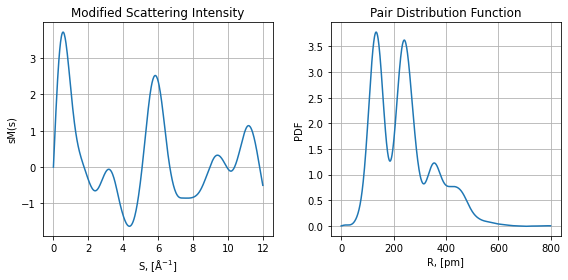

In [26]:
[coor,atom_sum]  = load_static_mol_coor(path_mol,mol_name,file_type);
[I,I_at,I_mol,s] = get_I_from_mol_coor(f,s000,s_max,coor,atom_sum);
[sM,PDF,r]       = get_sM_and_PDF_from_I(I_at,I_mol,s,r_max,damp_const)
# plot_I_sM_PDF(I,sM,PDF,s,r,mol_name+' I elastic',mol_name+' sM',mol_name+' PDF'); # use or not using plot-function 
plt.figure(figsize=(8,4))
    
plt.subplot(1,2,1)    
plt.plot(s,sM);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('sM(s)');plt.title('Modified Scattering Intensity');plt.grid()
    
plt.subplot(1,2,2)    
plt.plot(r,PDF);
plt.xlabel(r'R, [pm]');
plt.ylabel('PDF');
plt.title('Pair Distribution Function');
plt.grid()
    
plt.tight_layout()
plt.show()

In [27]:
def get_I_atomic(n, ds, s000, f, coor, atom_sum):
    I_at_all = []
    s000 = s000*1e-10
    for i in range(atom_sum):
        I_atomic = []
        I_at = 0
        amps = f[int(coor[i,4])]
        #print(amps)
        interp_amps = interp.interp1d(s000, amps)
        stop = n/2 * ds
        s_new = np.arange(0, stop, ds)
        amps_new = interp_amps(s_new)
        for k in range(len(amps_new)):
            f_new = amps_new[k]
            I_at = np.abs(f_new)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    I_at = sum(np.array(I_at_all))
    return I_at, s_new

In [28]:
I_at_new, s_new = get_I_atomic(1500, 0.0225, s000, f, coor, atom_sum)

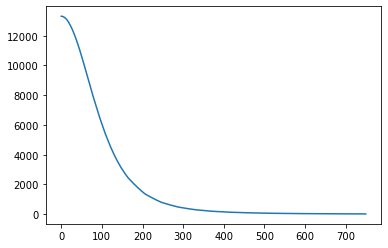

In [29]:
plt.figure()
#plt.plot(I_at)
plt.plot(I_at_new)
plt.show()

## Get Time Resolved Pattern

Add notes!

In [30]:
mol_name = 'CI2H2_time_evol'

coor, atom_sum, time = load_time_evolving_xyz(path_mol, mol_name, file_type)

count =  1150
4


In [31]:
f[6]

array([38.5648804 , 38.56475074, 38.56475074, 38.56475074, 38.56462109,
       38.56462109, 38.56449144, 38.56449144, 38.56436179, 38.56436179,
       38.56423213, 38.56410248, 38.56397282, 38.56397282, 38.56384317,
       38.56371351, 38.56358386, 38.5634542 , 38.56332455, 38.56306523,
       38.56293557, 38.56280591, 38.56267626, 38.56241694, 38.56228728,
       38.56202795, 38.56189829, 38.56163897, 38.56150931, 38.56124998,
       38.56099065, 38.56073132, 38.56047199, 38.56021266, 38.55995332,
       38.55969398, 38.55943464, 38.5591753 , 38.55606308, 38.55217244,
       38.54763287, 38.54244414, 38.53647623, 38.52985855, 38.52246098,
       38.51454271, 38.50571386, 38.49636346, 38.4862313 , 38.47544672,
       38.46400915, 38.45178799, 38.43891258, 38.42538224, 38.41119628,
       38.39622377, 38.38072433, 38.36443666, 38.34749014, 38.32975346,
       38.31148653, 38.29255802, 38.27283632, 38.25258161, 38.23166227,
       38.20994635, 38.18756342, 38.16464332, 38.141054  , 38.11

count =  1150
4


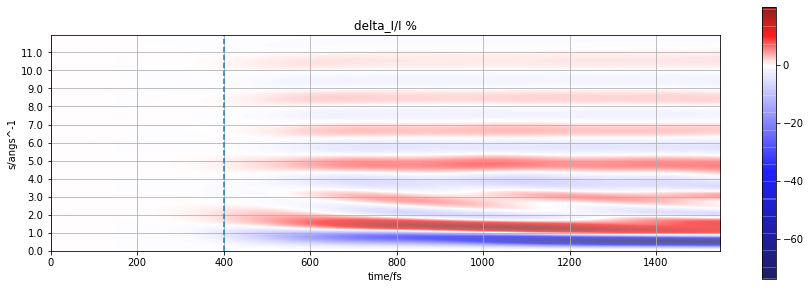

In [32]:
trajectory_sim(path_mol, mol_name, file_type, f, s000, s_max)

## Frequency Mode Diffraction Pattern

In [33]:
mol_name = 'cf3i_opt.hess.v008'
re, atom_sum, time = load_freq_xyz(path_mol, mol_name, file_type)
dI_I, new_time, s, PDF, r = freq_sim(path_mol, mol_name, file_type, f, s000, s_max)
PDF.shape

277.2042
fs= 120.6504665279664
277.2042
fs= 120.6504665279664


(200, 800)

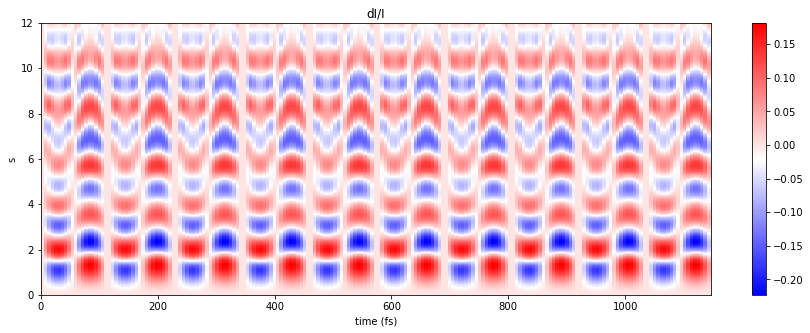

In [34]:
plt.figure(figsize=(15,5))
plt.pcolor(new_time, s, dI_I.T, cmap='bwr')
plt.colorbar()
plt.xlabel("time (fs)")
plt.ylabel("s")
plt.title("dI/I")
plt.show()

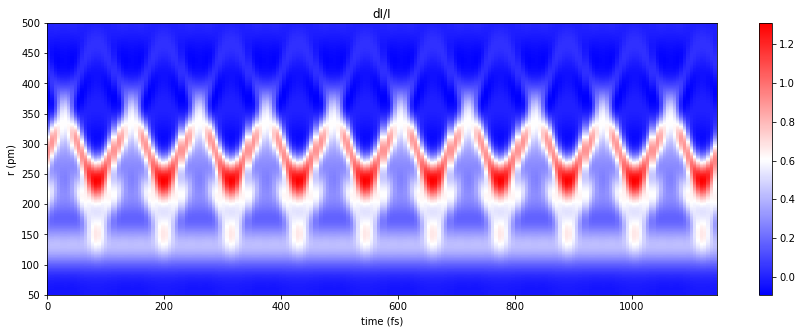

In [35]:
plt.figure(figsize=(15,5))
plt.pcolor(new_time, r, PDF.T, cmap='bwr')
plt.colorbar()
plt.xlabel("time (fs)")
plt.ylabel("r (pm)")
plt.ylim(50, 500)
plt.title("dI/I")
plt.show()